In [3]:
'''
The goal here is to understand how the D and G models are designed for a GAN and how they are put together and trained.
For this we need to :

    1. Select a One-Dimensional Function
    2. Define a Discriminator Model
    3. Define a Generator Model
    4. Train the Generator Model
    5. Evaluate the Performance of the GAN
    6. Putting it together
'''

'\nThe goal here is to understand how the D and G models are designed for a GAN and how they are put together and trained.\nFor this we need to :\n\n    1. Select a One-Dimensional Function\n    2. Define a Discriminator Model\n    3. Define a Generator Model\n    4. Train the Generator Model\n    5. Evaluate the Performance of the GAN\n    6. Putting it together\n'

In [1]:
# 1 - A 1D function -- y = (x**2)

def square(x):
    return x ** 2;

[-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.25, 0.16000000000000003, 0.09, 0.04000000000000001, 0.010000000000000002, 0.0, 0.010000000000000002, 0.04000000000000001, 0.09, 0.16000000000000003, 0.25]


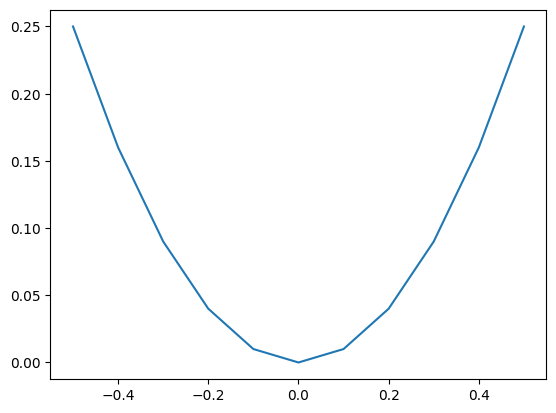

In [2]:
from numpy import arange
import matplotlib.pyplot as plt

inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0., 0.1, 0.2, 0.3, 0.4, 0.5]
print(inputs)

outputs = [square(i) for i in inputs]
print(outputs)

plt.plot(inputs, outputs)
plt.show()

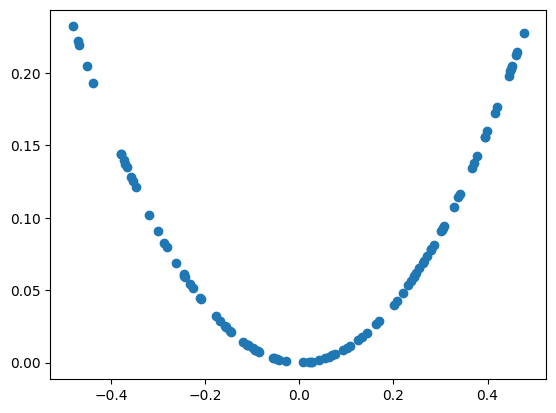

(100, 2)


In [3]:
# the goal of G here is to generate an output that resembles y(x) for inputs x
# for this the D needs to be trained on some samples from the domain

from numpy import hstack
from numpy.random import rand
from numpy import asarray

def random_samples(n = 100):
    X = rand(n) - 0.5
    Y = asarray([square(i) for i in X])

    X = X.reshape(n,1)
    Y = Y.reshape(n,1)

    return hstack((X, Y)) # hstack will join (n,1) (n,1) inputs to (n,2) -- basically joining by columns

samples = random_samples()
plt.scatter(samples[: ,0], samples[: ,1])
plt.show()
print(samples.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                75        
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 101 (404.00 Byte)
Trainable params: 101 (404.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


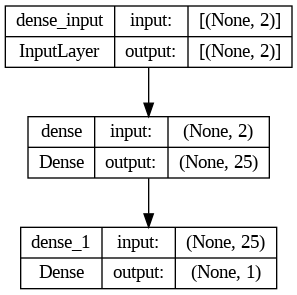

In [4]:
# 2 - The Discriminator Model

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

def make_D(dims_in = 2):
    model = Sequential([
        Dense(25, activation = 'relu', input_dim = dims_in, kernel_initializer='he_uniform'),
        Dense(1, activation = 'sigmoid')
    ])

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

Discriminator = make_D()

Discriminator.summary()
plot_model(Discriminator, show_shapes = True, show_layer_names = True)

In [5]:
# to under the working of the generator,
# lets make a function to make real_samples with label 1 (1 = real)

from numpy import ones
def real_samples(n = 100):
    X = rand(n) - 0.5
    Y = asarray([square(i) for i in X])

    X = X.reshape(n,1)
    Y = Y.reshape(n,1)
    X = hstack((X, Y))

    y = ones((n, 1))
    return X, y

# and another similar one to create fake samples
# for now, this serves the purpose of a generator for generating fake samples
from numpy import zeros
def fake_samples(n = 100):
    X = 2 * rand(n) - 1     # [-1,1]
    Y = 2 * rand(n) - 1     # also [-1,1] , making the mapping y = x (instead of y = x**2)

    X = X.reshape(n,1)
    Y = Y.reshape(n,1)
    X = hstack((X, Y))

    y = zeros((n, 1))
    return X, y

In [6]:
# now we'll define a function to train the discriminator. each batch is half real and half fake samples
# for each epoch we train it on one half batch first, then the other half batch

# note that the functions for real and fake samples generate random values,
# emulating picking of batches from a real dataset where values are distinct but similar

def train_discriminator(model, epochs = 200, batch = 128):
    half_batch = int(batch / 2)

    for i in range(epochs):

        # train on real half-batch
        X_real, y_real = real_samples(half_batch)
        model.train_on_batch(X_real, y_real)

        # train on fake half-batch
        X_fake, y_fake = fake_samples(half_batch)
        model.train_on_batch(X_fake, y_fake)

        #  evaluation
        _, acc_real = model.evaluate(X_real, y_real, verbose = 0)   # returns the loss value and specified metrics
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose = 0)

        if i % 50 == 0:
            print(i, acc_real, acc_fake)

In [15]:
train_discriminator(Discriminator) # run again to continue training

0 1.0 0.890625
50 1.0 0.84375
100 1.0 0.84375
150 1.0 0.90625


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                90        
                                                                 
 dense_3 (Dense)             (None, 2)                 32        
                                                                 
Total params: 122 (488.00 Byte)
Trainable params: 122 (488.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


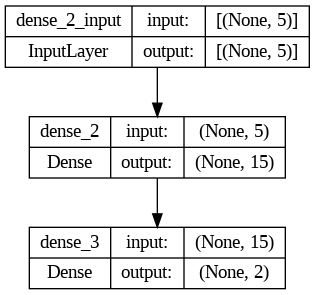

In [7]:
# 3 - The Generator Model

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

def make_G(latent_dims, dims_out = 2):
    model = Sequential([
        Dense(15, activation = 'relu', kernel_initializer = 'he_uniform', input_dim = latent_dims),
        Dense(dims_out, activation = 'linear')
    ])

    return model

Generator = make_G(5)  # we'll use a 5D latent space, i.e, each input is a vector with 5 elements

Generator.summary()
plot_model(Generator, show_shapes = True, show_layer_names = True)

In [8]:
# generate latent space

from numpy.random import randn

def generate_latent_space(latent_dims, n_points):

    X_latent = randn(n_points * latent_dims)
    X_latent = X_latent.reshape(n_points, latent_dims)

    return X_latent

In [9]:
# generate new samples using latent space
# making fake samples, will use them later
import matplotlib.pyplot as ply

def generate_new_samples(G, l_dims, n): # n = no. of fake samples to generate

    X_l = generate_latent_space(l_dims, n)
    fakes = G.predict(X_l)
    return fakes

    #plt.scatter(fakes[:, 0], fakes[:, 1])   # commented because this function is needed in another function ahead
    #plt.show()

4/4 [==============================] - 2s 613ms/step


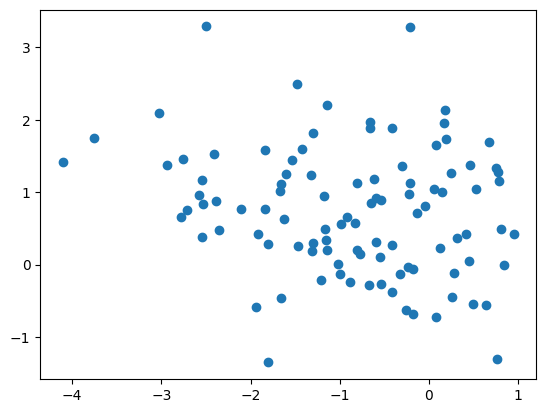

In [22]:
# imma tie this much together here for the G

latent_dims = 5
generate_new_samples(Generator, latent_dims, 100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 2)                 122       
                                                                 
 sequential (Sequential)     (None, 1)                 101       
                                                                 
Total params: 223 (892.00 Byte)
Trainable params: 122 (488.00 Byte)
Non-trainable params: 101 (404.00 Byte)
_________________________________________________________________


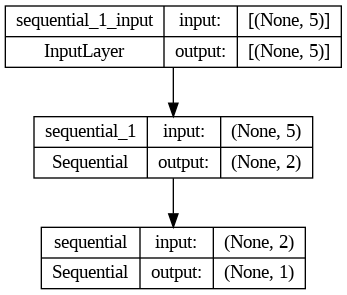

In [10]:
# 4 Train the G
# for this we need the weights from the D, but without training D on fake samples,
# so we define the GAN model

from keras.models import Sequential
from keras.utils import plot_model

def make_GAN(G, D):

    D.trainable = False

    model = Sequential()
    model.add(G)
    model.add(D)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

    return model

gan = make_GAN(Generator, Discriminator)
gan.summary()
plot_model(gan, show_shapes = True, show_layer_names = True)

In [12]:
# Training the GAN

from numpy import ones

def train_gan(G, D, gan, latent_dims, n_epochs = 10000, n_batch = 128, n_eval = 2000):
    half_batch = n_batch // 2

    for i in range(n_epochs):
        x_real, y_real = real_samples(half_batch)               # defined above generates a given number of x, x**2 pairs
        x_fake, y_fake = generate_new_samples(G, latent_dims, half_batch)   # defined above generates a given number of fake samples

        D.train_on_batch(x_real, y_real)
        D.train_on_batch(x_fake, y_fake)

        x_gan = generate_latent_space(latent_dims, n_batch)
        y_gan = ones((n_batch, 1))

        gan.train_on_batch(x_gan, y_gan)

        if (i+1) % n_eval == 0:
            view_performance(i, G, D, latent_dims) # added in the next section

# train_on_batch is used to get the loss for the fake samples batch (which gives a measure for G to improve)
# note that the D is just trained standalone first, on both fake and real images
# this means that as D improves, G will improve also
# also note that the gan model itself has D layers as non-trainable, which means that only G is being updated in it

In [11]:
# 5 Subjective Evaluation
# the function y(x) = x**2 makes the objective evaluation of this gan possible and pretty straight forward
# however most of regular applications of gans will not allow this
# so we'll evaluate this one subjectively, as are most gans, to get a feel hehe

import matplotlib.pyplot as plt
def view_performance(epoch, G, D, latent_dims, n = 100): # n is the batch size
    x_real, y_real = real_samples(n)
    x_fake, y_fake = generate_new_samples(G, latent_dims, n)

    _, acc_real = D.evaluate(x_real, y_real, verbose = 0)
    _, acc_fake = D.evaluate(x_fake, y_fake, verbose = 0)

    print(epoch, acc_real, acc_fake)

    plt.scatter(x_real[:, 0], x_real[:, 1], color='r')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='b')
    plt.show()

In [ ]:
'''
the D and G have be created, gan has been defined as G+D
the training algo is defined
evaluation procedure has been put in place
and now I only need to put the call the train_gan() :-D

but not here, not yet -_-

that will cause a mess in this notebook.
I'll make a different one for the standalone gan
'''